# Validation of analytical covariance

## Monte carlo simulation

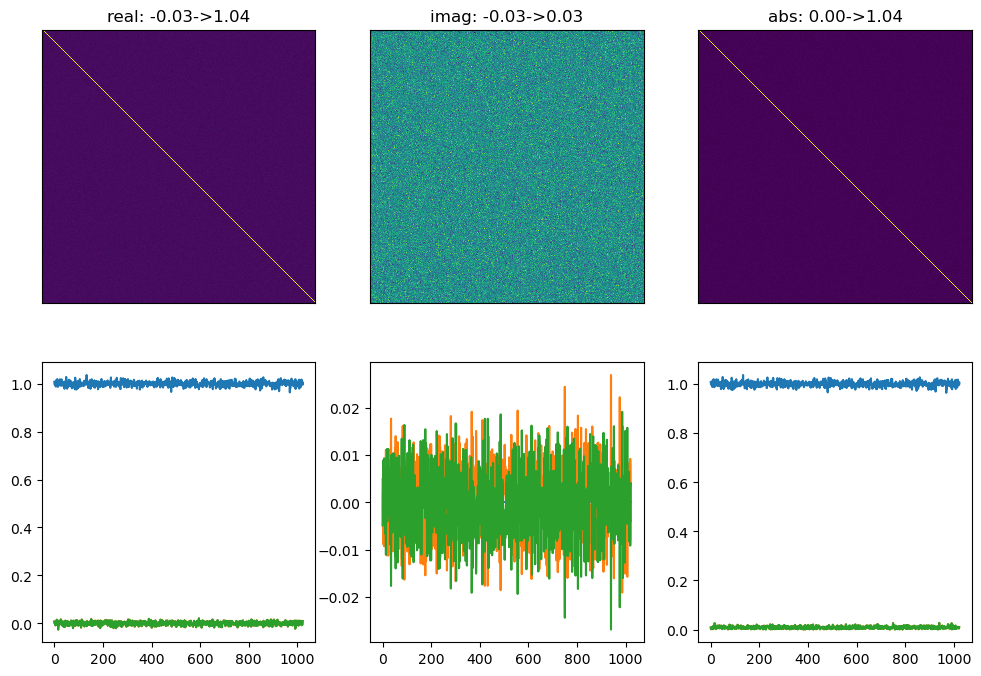

In [211]:
import numpy as np
import matplotlib.pyplot as plt

noise_sd = 1
npoints = 1024
nsamples = 10000
rng = np.random.default_rng()
original_noise = noise_sd / np.sqrt(2) * rng.standard_normal((npoints, nsamples)) + 1j * noise_sd / np.sqrt(2) * rng.standard_normal((npoints, nsamples))

original_cov = np.cov(original_noise)

def my_fft(x, axis=0):
    return np.fft.fftshift(
        np.fft.fft(
            x,
            axis=axis,
            norm='ortho'),
        axes=axis)

def plot_cov(cov_mat: np.ndarray) -> plt.Figure:
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0, 0].matshow(np.real(cov_mat))
    axes[0, 1].matshow(np.imag(cov_mat))
    axes[0, 2].matshow(np.abs(cov_mat))
    for ax in axes[0]:
        ax.set_xticks([])
        ax.set_yticks([])

    for idx, name in enumerate([
            ('real', np.real), 
            ('imag', np.imag),
            ('abs', np.abs)]):
        axes[0, idx].set_title(f'{name[0]}: {np.min(name[1](cov_mat)):0.2f}->{np.max(name[1](cov_mat)):0.2f}')

    axes[1, 0].plot(np.diag(np.real(cov_mat)))
    axes[1, 0].plot(np.diag(np.real(cov_mat), k=1))
    axes[1, 0].plot(np.diag(np.real(cov_mat), k=-1))
    axes[1, 1].plot(np.diag(np.imag(cov_mat)))
    axes[1, 1].plot(np.diag(np.imag(cov_mat), k=1))
    axes[1, 1].plot(np.diag(np.imag(cov_mat), k=-1))
    axes[1, 2].plot(np.diag(np.abs(cov_mat)))
    axes[1, 2].plot(np.diag(np.abs(cov_mat), k=1))
    axes[1, 2].plot(np.diag(np.abs(cov_mat), k=-1))
    plt.show()
    return fig

fig = plot_cov(original_cov)

### Define apodisation window and function

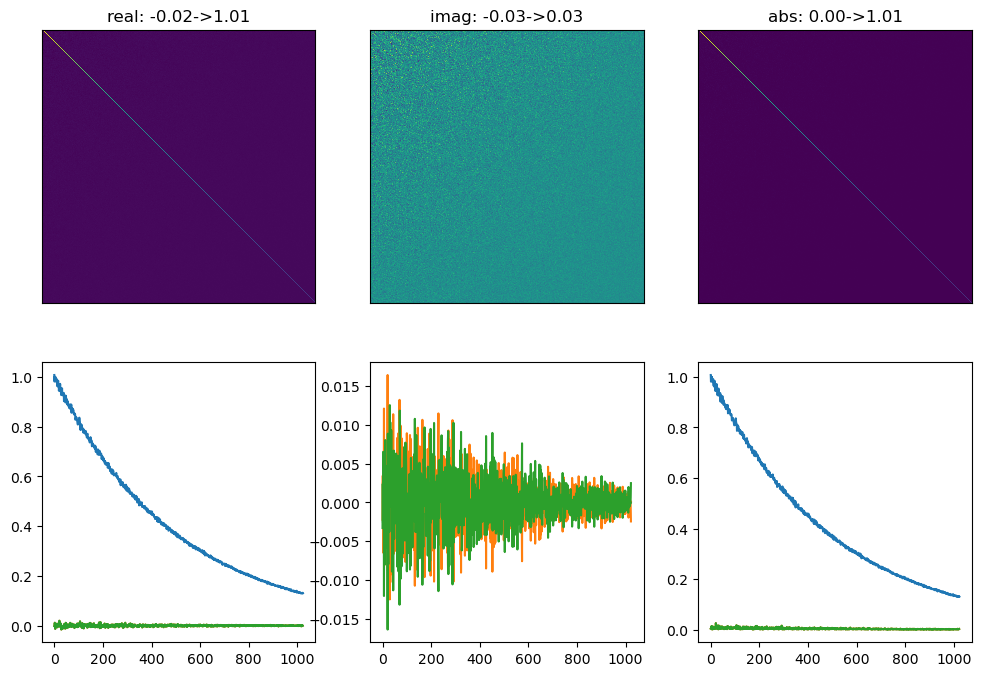

In [129]:
def apod_window(size: int, dwelltime: float, broadening: float) -> np.ndarray:
    taxis = np.linspace(0, dwelltime * (size - 1), size)
    Tl = 1 / broadening
    return np.exp(-taxis / Tl)

def apodise(data: np.ndarray, dwelltime: float, broadening: float) -> np.ndarray:
    window = apod_window(data.shape[0], dwelltime, broadening)
    return window[:, np.newaxis] * data

apodised_noise = apodise(original_noise, 1, 0.001)

apodised_cov = np.cov(apodised_noise)

fig = plot_cov(apodised_cov)

## Covariance in frequency domain (after FT)

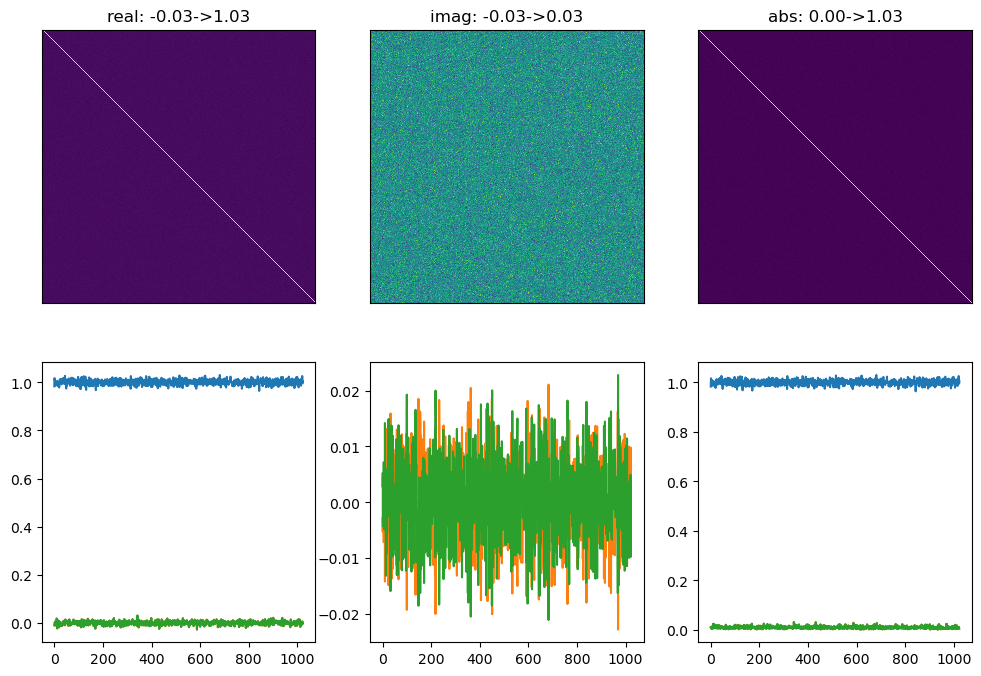

In [130]:
fft_noise = my_fft(original_noise, axis=0)
fft_cov = np.cov(fft_noise)

fig = plot_cov(fft_cov)

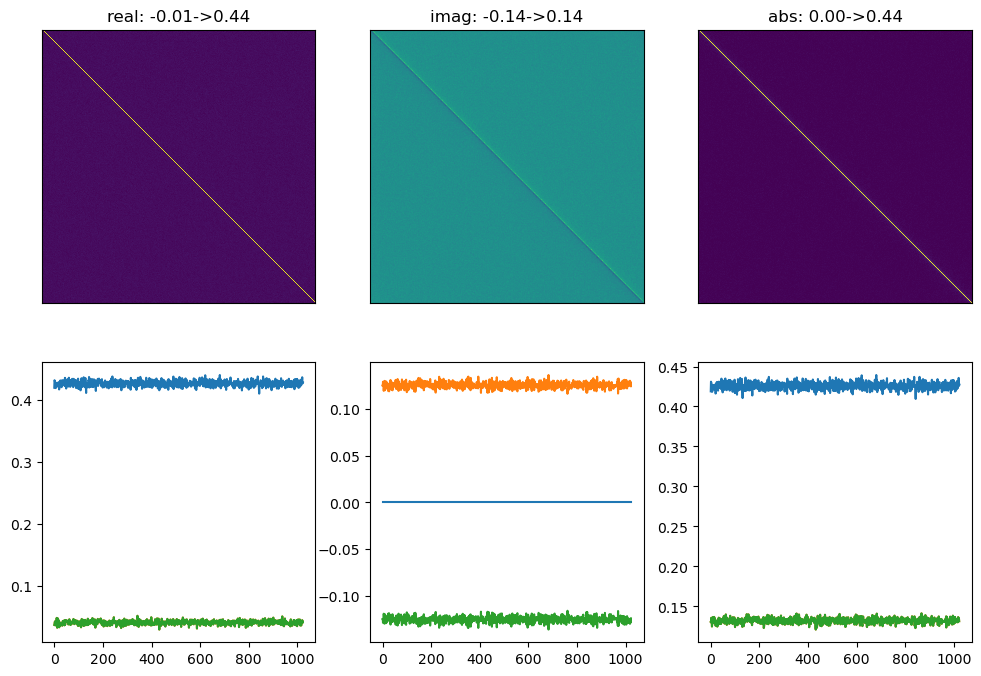

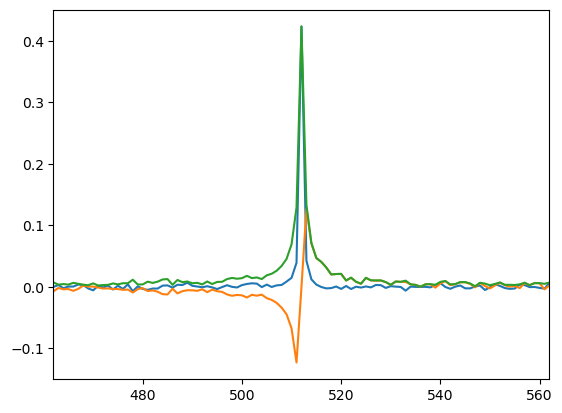

In [131]:
fft_apod_noise = my_fft(apodised_noise, axis=0)
fft_apod_cov = np.cov(fft_apod_noise)

fig = plot_cov(fft_apod_cov)

plt.plot(fft_apod_cov.real[512,:])
plt.plot(fft_apod_cov.imag[512,:])
plt.plot(np.abs(fft_apod_cov)[512,:])
plt.xlim([512-50, 512+50])
plt.show()

## Analytical expression for covariance + numerical window

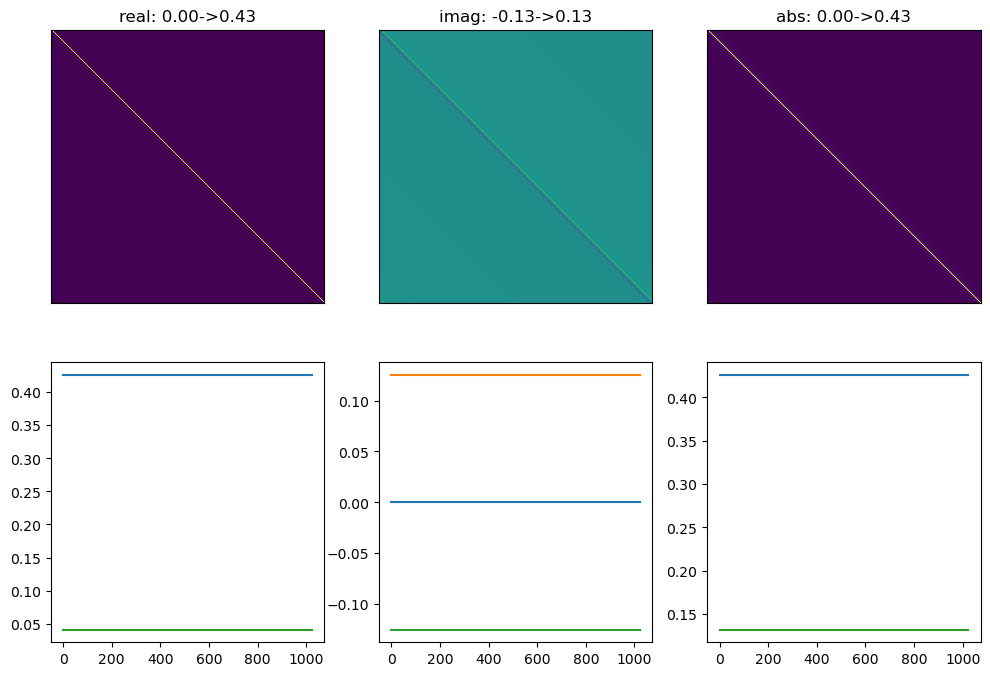

In [212]:
from scipy.linalg import circulant
def make_windowed_cov(window: np.array, noise_sd: float) -> np.ndarray:
    fft_ortho_scale_factor = 1 / np.sqrt(window.size)
    scaled_fft_window = my_fft(window ** 2) * noise_sd ** 2 * fft_ortho_scale_factor
    return circulant(np.fft.fftshift(scaled_fft_window))
direct_cov = make_windowed_cov(
    apod_window(npoints, 1, 0.001),
    noise_sd
)
fig = plot_cov(direct_cov)

## Purely analytical covariance

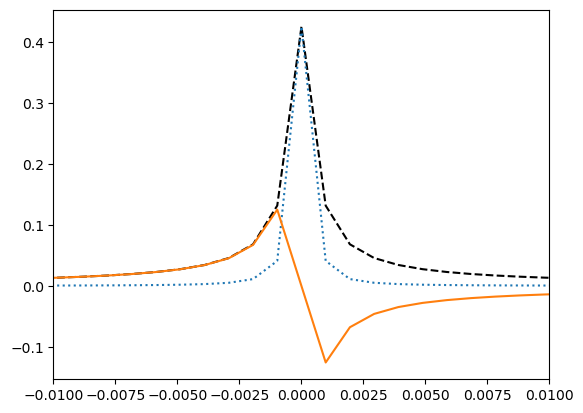

In [217]:
apod = 0.001
faxis = np.fft.fftshift(np.fft.fftfreq(npoints))


def dft_exp(gamma, f):
    N = f.size
    return (1 / N) * (1 - np.exp(-2 * gamma * N)) / (
        1 - np.exp(-2 * gamma) * np.exp(-1j * 2 * np.pi * f)
    )


analytical = dft_exp(apod, faxis)

plt.plot(faxis, np.abs(analytical),'k--')
plt.plot(faxis, np.real(analytical),':')
plt.plot(faxis, np.imag(analytical))
plt.xlim([-0.01, 0.01])
plt.show()

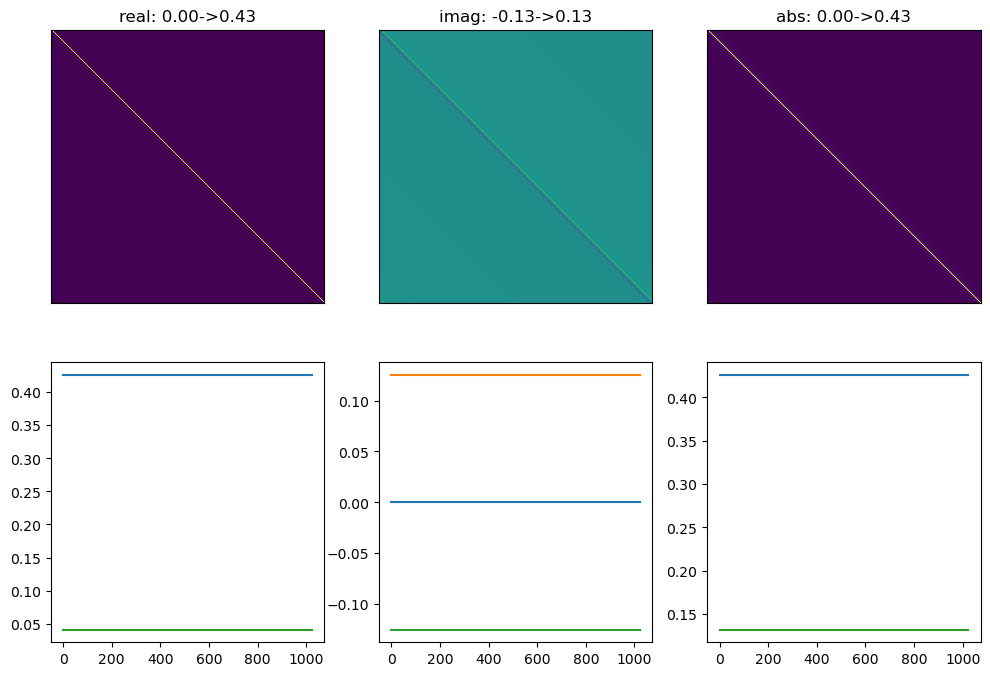

In [219]:
def cov_analytical(faxis: np.ndarray, gamma: float, noise_sd: float):
    scaled_function = noise_sd**2 * dft_exp(gamma, faxis)
    return circulant(np.fft.fftshift(scaled_function))


analytical_cov = cov_analytical(
        faxis,
        0.001,
        noise_sd)

_ = plot_cov(analytical_cov)


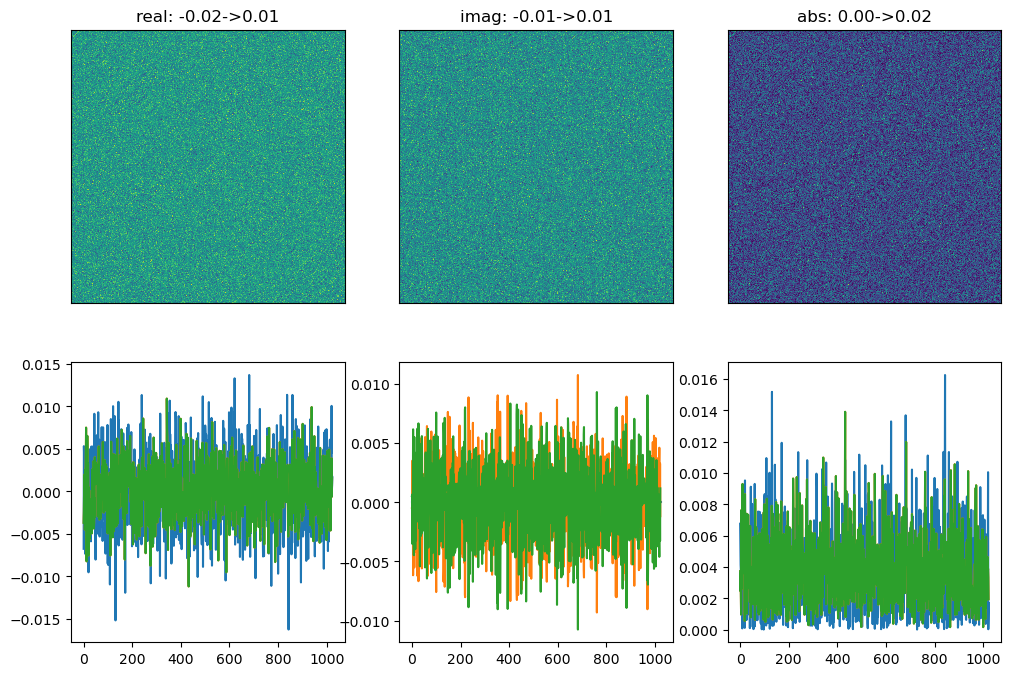

In [221]:
# Both. analytical methods match
assert np.allclose(direct_cov, analytical_cov)

# And closely match simulation
fig = plot_cov(fft_apod_cov-direct_cov)